# Example of robovetting on WASP-18b using the exovetter package

In [1]:
import requests
import lightkurve as lk
from astropy import units as u

import pandas as pd
import numpy as np

from exovetter.tce import Tce
from exovetter import const as exo_const
from exovetter import vetters as vet

import matplotlib.pyplot as plt
%matplotlib inline

## TCE and lightcurve

A Threshold Crossing Event (TCE) is an object that contains the transit ephemeris and basic parameters that usually come out of a transit search pipeline (such as period, epoch, snr, depth, etc). We can create one using the built in Tce function from the tce class. The object only requires 'depth', 'duration', 'epoch', 'epoch_offset', and 'period' but can take more. These required parameters are forced to be in astropy units to ensure the transit is modeled correctly.

We can pull down all the required information to create the TCE from exo.mast's API.

In [2]:
# Obtain a dictionary containing all required info on the target from exo.mast
r = requests.get(url = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/WASP-18 b/properties/") 
planet_prop = r.json() # Returns a JSON object of the result
nexsci_prop = planet_prop[1]  # Take the result from the nexsci catalog

# Use the Tce function to create a tce object
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Validate that all required parameters are present with the validate method
print(f"All required parameters present: {tce.validate()}")

# View the tce
display(tce)

All required parameters present: True


{'period': <Quantity 0.94145223 d>,
 'epoch': <Quantity 58374.669883 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.00931894>,
 'duration': <Quantity 0.08932 d>,
 'snr': 50,
 'event_name': 'WASP-18 b',
 'target_name': 'WASP-18'}

We use the lightkurve package to pull down sector 3 data for TESS data on this object. See more at https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html We then flatten that data to remove any remaining instrumental systematics. Combining this lightcurve with the TCE object allows us to perform vetting.

MAST search result for WASP-18b:


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 03,2018,QLP,1800,100100827,0.0
3,TESS Sector 03,2018,TASOC,120,100100827,0.0
4,TESS Sector 03,2018,GSFC-ELEANOR-LITE,1800,100100827,0.0
5,TESS Sector 03,2018,TASOC,1800,100100827,0.0
6,TESS Sector 03,2018,TASOC,1800,100100827,0.0
7,TESS Sector 03,2018,TGLC,1800,100100827,0.0



Lightkurve file for the TESS-SPOC result for WASP-18b:


time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1385.9730080719391,9.9968830e-01,1.3710011e-04,3.6870595e-03,7608,735.48113,506.33493,4.5797773e+04,6.2033610e+00,1.9915616e+03,1.5031656e+00,4.7456918e+04,6.5083776e+00,0,———,———,———,———,735.48113,1.2508544e-04,506.33493,1.3699416e-04,2.1829026e-02,-1.2350826e-03
1385.9938413058178,9.9930304e-01,1.3707345e-04,3.6869685e-03,7609,735.48145,506.33447,4.5780402e+04,6.2021551e+00,1.9910179e+03,1.5023760e+00,4.7438629e+04,6.5071115e+00,0,———,———,———,———,735.48145,1.2511462e-04,506.33447,1.3701258e-04,2.2275314e-02,-1.7714109e-03
1386.0146745389982,9.9946424e-01,1.3709358e-04,3.6868767e-03,7610,735.48238,506.33443,4.5788562e+04,6.2030654e+00,1.9891464e+03,1.5030468e+00,4.7446281e+04,6.5080671e+00,0,———,———,———,———,735.48238,1.2509718e-04,506.33443,1.3699899e-04,2.3293758e-02,-1.6642722e-03
1386.035507771713,9.9998247e-01,1.3713323e-04,3.6867845e-03,7611,735.48212,506.33479,4.5813191e+04,6.2048593e+00,1.9910524e+03,1.5039760e+00,4.7470883e+04,6.5099497e+00,0,———,———,———,———,735.48212,1.2505279e-04,506.33479,1.3694583e-04,2.2844512e-02,-1.4888856e-03
1386.056341003729,9.9994890e-01,1.3711595e-04,3.6866916e-03,7612,735.48184,506.33434,4.5809582e+04,6.2040777e+00,1.9902479e+03,1.5026495e+00,4.7469289e+04,6.5091290e+00,0,———,———,———,———,735.48184,1.2505047e-04,506.33434,1.3700601e-04,2.2809040e-02,-1.8232776e-03
1386.0771742352788,1.0001743e+00,1.3712670e-04,3.6865983e-03,7613,735.48253,506.33505,4.5822012e+04,6.2045646e+00,1.9881403e+03,1.5017873e+00,4.7479988e+04,6.5096397e+00,0,———,———,———,———,735.48253,1.2504196e-04,506.33505,1.3691600e-04,2.3537286e-02,-1.0025661e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406.097695120284,1.0000143e+00,1.3707992e-04,3.3822574e-03,8574,735.44707,506.34914,4.5788891e+04,6.2018633e+00,1.9847842e+03,1.5008553e+00,4.7467918e+04,6.5068054e+00,0,———,———,———,———,735.44707,1.2519215e-04,506.34914,1.3718643e-04,-1.4524973e-02,1.3044920e-02


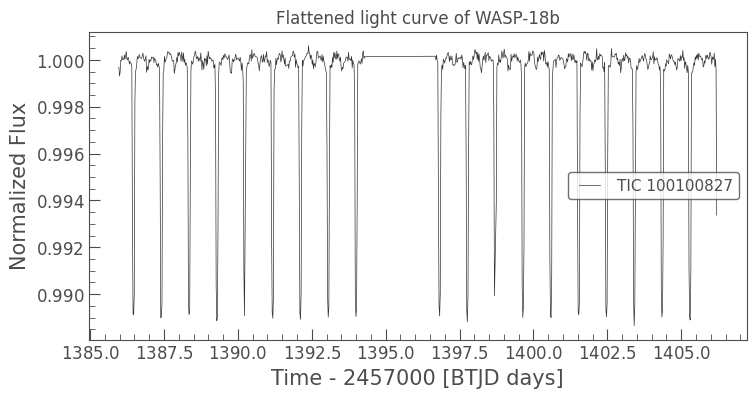

In [3]:
# Search MAST for lightcurves centered around the target 
lk_search = lk.search_lightcurve(target = 'TIC100100827', mission = "TESS", sector = 3) 

# Download the TESS-SPOC dataset, remove nans and outliers, then flatten the light curve
lcf = lk_search[1].download()
lcf.select_flux(flux_column="sap_flux") # Reassign the flux and flux err to the SAP flux and err
lc = lcf.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

# View what the MAST search returned
print("MAST search result for WASP-18b:")
display(lk_search)

# View the cleaned and flattened lightkurve file
print("\nLightkurve file for the TESS-SPOC result for WASP-18b:")
display(flat)

# Plot the flattened lightcurve
ax = flat.plot()
ax.set_title("Flattened light curve of WASP-18b");
plt.show()

## Running a suite of vetters on this lightcurve

Each vetter is initialized as an object and has a run and plot method. Some vetters require different inputs to initialize them, but all can take the name of the flux array you would like to use from the lightkurve object (default is just "flux"). The run method can similary take more parameters but only requires the names of the tce and lightcurve. The run method returns a dictionary with the data revevent to the given vetter. 

As an example we run six vetters on the tce/lightcurve: lpp, modshift, odd even, transit phase coverage, and single event stats. 


In [4]:
# Initialize the desired vetters with their default parameters
lpp = vet.Lpp()
modshift = vet.ModShift()
odd_even = vet.OddEven()
transit_phase_coverage = vet.TransitPhaseCoverage()

# Run each vetter on the tce and flattened lightcurve
lpp_results = lpp.run(tce, flat)
modshift_results = modshift.run(tce, flat)
odd_even_results = odd_even.run(tce, flat)
transit_phase_coverage_results = transit_phase_coverage.run(tce, flat)


Single event stats: Cadence length not specified, calculated from time array to be: 29.99985577975167 minutes
SNR metrics: could not get positive significance, no uni_phs_pos result


## Populate a dataframe with some of these results

To demonstrate a way of collecting data from these result dictionaries we fill a pandas dataframe with some select results we might be interested in. 


In [5]:
# Create a convenience function to fill the data frame with portions of the results dicts
def populate_vetter_list(results_dict, vetter_name, results_range=None):
    """Populate a list with the results from a vetters dictionary
    
    Parameters
    ----------
    results_dict : dict
        dictionary with values to pull from.
        
    vetter_name : str
        name of the vetter to shorten the formatting of the resulting df.
        
    results_range : tuple 
        tuple of start and stop indices for desired range of values.
    
    Returns
    -------
    results_list : tuple
        list of two lists, the first containing the values and the second
        containing the keys of the desired results_dict.
    """
    
    if results_range is None:
        key_list = list(results_dict.keys())
        value_list = list(results_dict.values())
        vetters_list = [vetter_name] + [''] * (len(value_list)-1)
        return vetters_list, key_list, value_list
        
    else:
        key_list = list(results_dict.keys())[results_range[0]:results_range[1]+1]
        value_list = list(results_dict.values())[results_range[0]:results_range[1]+1]
        vetters_list = [vetter_name] + [''] * (len(value_list)-1)
        return vetters_list, key_list, value_list 


In [6]:
# Create lists of some of the returned values
lpp_vetters, lpp_metrics, lpp_values = populate_vetter_list(lpp_results, 'LPP', (0,1))
modshift_vetters, modshift_metrics, modshift_values = populate_vetter_list(modshift_results, 'Modshift')
odd_even_vetters, odd_even_metrics, odd_even_values = populate_vetter_list(odd_even_results, 'Odd Even')
transit_phase_coverage_vetters, transit_phase_coverage_metrics, transit_phase_coverage_values = populate_vetter_list(transit_phase_coverage_results, 'Transit phase coverage')

# Combine these lists into three long lists to pass into pandas.DataFrame
vetter = lpp_vetters + modshift_vetters + odd_even_vetters + transit_phase_coverage_vetters
metrics = lpp_metrics + modshift_metrics + odd_even_metrics + transit_phase_coverage_metrics
values = lpp_values + modshift_values + odd_even_values + transit_phase_coverage_values

# Put these in a dataframe for visibility 
df = pd.DataFrame([vetter, metrics, values]).transpose()
df.columns = ['vetter', 'metric', 'value']
display(df)


,vetter,metric,value
0,LPP,raw_lpp,0.012743
1,,norm_lpp,15.142315
2,Modshift,pri,0
3,,phase_pri,0.0
4,,sec,53
5,,phase_sec,0.475209
6,,ter,0
7,,phase_ter,0.0
8,,pos,NaN
9,,phase_pos,NaN
